# Data Science

`-` 최적화문제, tf.keras.optimizers를 이용한 최적화방법, 1.optimizers.apply_gradients( ), 2.optimizers.minimize( ), 회귀분석

- lenture: Data Science_5-1nd week of lectures.
- lenture date: 2022-03-30
- lecturer: Guebin choi
- study date: 2022-03-30
- author: Kione kim

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow.experimental.numpy as tnp

In [3]:
tnp.experimental_enable_numpy_behavior()

## 최적화문제

`-` $loss=(\frac{1}{2}\beta-1)^2$ 

`-` 기존의 학습
$$\beta_{next} \leftarrow \beta_{old} -\alpha \left[\frac{\partial}{\partial \beta} loss(\beta)\right]_{\beta=\beta_{old}}$$

``` python
beta = tf.Variable(-10.0) 
alpha=0.01/6 

for k in range(100): 
    with tf.GradientTape(persistent=True) as tape: 
        loss = (beta/2-1)**2 
    beta.assign_sub(alpha*tape.gradient(loss,beta))

beta
```

`-` 이 방식의 단점: 
- 위의 식을 알고 있어야 함
- 사람들 생각: (위의 식을 알지 정확하게 알지 못하더라도) $β_{old}$ 에서의 미분값과 $β_{old}$(현재 위치)를 통해 $β_{new}$(좀 더 나은 $β$)가 나오는 정도만 알고 있으면, 이미 구현되어 있는 식(위의 식)에 값을 넣기만 하면 계산되는 프로세스를 만들 수 있지 않을까?
- 그래서 만든 것: `optimizer`

## tf.keras.optimizers를 이용한 최적화방법

### 방법1: opt.apply_gradients()를 이용

`-` optimizer 정의   
: 학습율 함께 정의

In [4]:
alpha=0.01/6

In [5]:
opt=tf.keras.optimizers.SGD(learning_rate=alpha)

---

In [6]:
opt.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0016666667>

In [7]:
opt.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0016666667>

In [8]:
id(opt.learning_rate)

2567521054336

In [9]:
id(opt.lr)

2567521054336

- opt.learning_rate와 opt.lr은 같은 것임, 둘 중 쓰고 싶은 것 쓰면 됨!

---

`-` optimizer에 들어갈 입력값 정리
- beta
- beta에서의 미분값

In [10]:
beta= tf.Variable(-10.0)
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-10.0>

In [11]:
with tf.GradientTape(persistent=True) as mytape:
    loss=(beta/2 -1)**2
slope=mytape.gradient(loss,beta) # 기울기라는 변수로 저장
slope

<tf.Tensor: shape=(), dtype=float32, numpy=-6.0>

`-` .apply_gradients()

In [12]:
opt.apply_gradients([(slope, beta)]) # 튜플의 리스트화하여 입력

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [13]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.99>

- beta값이 바꼈음
- 이 값은 -10에서 0.01만큼 움직인 값임! -> 베타를 한 번 업데이트한 값
- 즉, 위 과정은 **iter1**과 같음
- 여기서 주의점: `opt.apply_gradients()`의 입력으로 pair의 list를 전달해야한다는 것

`-` **iter2**

In [14]:
with tf.GradientTape(persistent=True) as mytape:
    loss=(beta/2 -1)**2
slope=mytape.gradient(loss,beta)

In [15]:
opt.apply_gradients([(slope, beta)]) # 튜플의 리스트화하여 입력

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=2>

In [16]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.980008>

- 한 번 더 업데이트 되었음

`-` **iter3:for문을 통한 반복**

In [17]:
alpha=0.01/6
opt=tf.keras.optimizers.SGD(alpha)
beta=tf.Variable(-10.0)

In [18]:
for epoc in range(10000):
    with tf.GradientTape() as mytape:
        loss=(beta/2 -1)**2
    slope=mytape.gradient(loss,beta)
    opt.apply_gradients([(slope,beta)])

In [19]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9971251>

- 그런데 이게 더 어려운 것 아닌가..?
- 차라리 식을 아는 게 더 편한 것 같음

- 하지만, 외워야 할 식이 하나만 있는 것이 아니다..! 여러가지 최적화 방법들이 존재.. 각각의 방법들이 식이 조금씩 다르다
- 따라서 옵티마이저를 쓰는 방법을 알고 있으면 식을 알지 못하더라도 계산할 수 있다
- 결국은 옵티마이저를 쓰는 게 편리하다!

### 방법2: opt.minimize()를 이용

``` python
opt.apply_gradients()는 loss식 & beta(old)값 & beta(old)에서의 기울기(slope)를 전달해주면 되는 반면
opt.minimize()는 loss식 & loss식을 무엇으로 미분할지만 전달해주면 알아서 계산해준다.
```

`-` α, β, optimizer 선언

In [21]:
alpha=0.01/6
opt=tf.keras.optimizers.SGD(alpha)
beta=tf.Variable(-10.0)

In [22]:
opt.minimize?

Signature: opt.minimize(loss, var_list, grad_loss=None, name=None, tape=None)
Docstring:
Minimize `loss` by updating `var_list`.

This method simply computes gradient using `tf.GradientTape` and calls
`apply_gradients()`. If you want to process the gradient before applying
then call `tf.GradientTape` and `apply_gradients()` explicitly instead
of using this function.

Args:
  loss: `Tensor` or callable. If a callable, `loss` should take no arguments
    and return the value to minimize. If a `Tensor`, the `tape` argument
    must be passed.
  var_list: list or tuple of `Variable` objects to update to minimize
    `loss`, or a callable returning the list or tuple of `Variable` objects.
    Use callable when the variable list would otherwise be incomplete before
    `minimize` since the variables are created at the first time `loss` is
    called.
  grad_loss: (Optional). A `Tensor` holding the gradient computed for
    `loss`.
  name: (Optional) str. Name for the returned operation.
  ta

- loss를 함수의 형태로 전달해야 함!

In [23]:
loss_fn= lambda: (beta/2-1)**2

In [24]:
opt.minimize(loss_fn,beta)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

- `numpy=1`은 1번 업데이트 했다는 의미

In [25]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.99>

- $β$값을 보니 $-10.0$에서 한 번 업데이트한 값인 $-9.99$이 나타났음
- 즉, 위 과정은 **iter1**과 같음

`-` **iter2:for문을 통한 반복**

In [26]:
alpha=0.01/6
opt=tf.keras.optimizers.SGD(alpha)
beta=tf.Variable(-10.0)
loss_fn= lambda: (beta/2-1)**2

In [27]:
for epoc in range(10000):
    opt.minimize(loss_fn,beta)

In [28]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9971251>

- 2에 근접한 값이 나왔음

In [29]:
loss_fn

<function __main__.<lambda>()>

In [30]:
loss_fn()

<tf.Tensor: shape=(), dtype=float32, numpy=2.0661923e-06>

- 위 값은 현재시점 β에 해당하는 loss값이다.
- 다시 말해, `loss_fn()`을 실행하면, 현재시점에서의 $(beta/2-1)**2$ 값이 출력된다.

### 기타

`-` `tf.keras.optimizers.SGD`와 `tf.optimizers.SGD`의 차이점

In [31]:
_opt1=tf.keras.optimizers.SGD()
_opt2=tf.optimizers.SGD()

In [32]:
type(_opt1), type(_opt2)

(keras.optimizer_v2.gradient_descent.SGD,
 keras.optimizer_v2.gradient_descent.SGD)

- type이 같음!

`-` `tf.optimizers.SGD`로 위의 과정 계산

In [33]:
alpha=0.01/6
opt=tf.optimizers.SGD(alpha)
beta=tf.Variable(-10.0)
loss_fn= lambda: (beta/2-1)**2

In [34]:
for epoc in range(10000):
    opt.minimize(loss_fn,beta)

In [35]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9971251>

- 똑같은 값이 나옴 -> 같은 기능

`-` 다른 방법

In [36]:
tf.optimizers?

Type:        module
String form: <module 'keras.api._v2.keras.optimizers' from 'C:\\Users\\kko\\anaconda3\\envs\\ds2022\\lib\\site-packages\\keras\\api\\_v2\\keras\\optimizers\\__init__.py'>
File:        c:\users\kko\anaconda3\envs\ds2022\lib\site-packages\keras\api\_v2\keras\optimizers\__init__.py
Docstring:   Public API for tf.keras.optimizers namespace.


In [37]:
tf.keras.optimizers?

Type:        module
String form: <module 'keras.api._v2.keras.optimizers' from 'C:\\Users\\kko\\anaconda3\\envs\\ds2022\\lib\\site-packages\\keras\\api\\_v2\\keras\\optimizers\\__init__.py'>
File:        c:\users\kko\anaconda3\envs\ds2022\lib\site-packages\keras\api\_v2\keras\optimizers\__init__.py
Docstring:   Public API for tf.keras.optimizers namespace.


- 파일이 위치한 장소가 같음!

- 차이 없음!

## 회귀분석

`-` ${\bf y} \approx 4 + 2.5 {\bf x}$에서 $4$와 $2.5$를 모른다고 생각하고 $β_{0}, β_{1}$를 구하는 방법

`-` 선언

In [53]:
tnp.random.seed(50000)
n= 500 # samplesize
x= tnp.linspace(0,1,n)
epsilon= tnp.random.randn(n)*0.5

In [54]:
y=4+2.5*x+epsilon
y_true=4+2.5*x

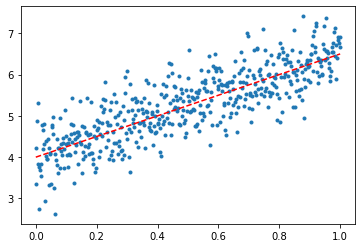

In [55]:
plt.plot(x,y,'.')
plt.plot(x,y_true,'--r')

- 파란색 점들을 통해 빨강색 점을 추론

### 풀이1 : $\beta$구하는 공식을 통한 풀이

In [71]:
tnp.random.seed(50000)
n= 500 
x= tnp.linspace(0,1,n)
epsilon= tnp.random.randn(n)*0.5
y=4+2.5*x+epsilon

In [72]:
Sxx= sum((x-np.mean(x))**2)
Sxy= sum((x-np.mean(x))*(y-np.mean(y)))

In [73]:
beta1_h = Sxy/Sxx
beta0_h = np.mean(y) - beta1_h*np.mean(x)

In [74]:
beta0_h,beta1_h

(<tf.Tensor: shape=(), dtype=float64, numpy=4.043123346730244>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.4858994002326082>)

- 거의 근접한 값이 나옴

### 풀이2 : 벡터 & 매트릭스를 이용한 풀이

In [103]:
tnp.random.seed(50000)
n= 500 
x= tnp.linspace(0,1,n)
epsilon= tnp.random.randn(n)*0.5
y=4+2.5*x+epsilon

`-` `X`선언

In [104]:
x[:20]

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603,
       0.01002004, 0.01202405, 0.01402806, 0.01603206, 0.01803607,
       0.02004008, 0.02204409, 0.0240481 , 0.0260521 , 0.02805611,
       0.03006012, 0.03206413, 0.03406814, 0.03607214, 0.03807615])>

In [105]:
tf.ones(n)[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>

In [106]:
X=tf.stack([tf.ones(n,dtype='float64'),x],axis=1)
X[:20]

<tf.Tensor: shape=(20, 2), dtype=float64, numpy=
array([[1.        , 0.        ],
       [1.        , 0.00200401],
       [1.        , 0.00400802],
       [1.        , 0.00601202],
       [1.        , 0.00801603],
       [1.        , 0.01002004],
       [1.        , 0.01202405],
       [1.        , 0.01402806],
       [1.        , 0.01603206],
       [1.        , 0.01803607],
       [1.        , 0.02004008],
       [1.        , 0.02204409],
       [1.        , 0.0240481 ],
       [1.        , 0.0260521 ],
       [1.        , 0.02805611],
       [1.        , 0.03006012],
       [1.        , 0.03206413],
       [1.        , 0.03406814],
       [1.        , 0.03607214],
       [1.        , 0.03807615]])>

In [107]:
y[:20]

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([3.35275314, 4.22611941, 4.87242315, 5.31953133, 3.8417442 ,
       2.7444039 , 3.75847533, 3.67882462, 3.84180216, 3.54850093,
       4.77493479, 4.64718767, 4.2011182 , 4.31115921, 4.81145538,
       2.94308534, 4.03927822, 4.3866718 , 3.96485239, 3.96641934])>

In [108]:
y=y.reshape(n,1)

In [109]:
y[:20]

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[3.35275314],
       [4.22611941],
       [4.87242315],
       [5.31953133],
       [3.8417442 ],
       [2.7444039 ],
       [3.75847533],
       [3.67882462],
       [3.84180216],
       [3.54850093],
       [4.77493479],
       [4.64718767],
       [4.2011182 ],
       [4.31115921],
       [4.81145538],
       [2.94308534],
       [4.03927822],
       [4.3866718 ],
       [3.96485239],
       [3.96641934]])>

In [110]:
X.shape,Y.shape

(TensorShape([500, 2]), TensorShape([500, 1]))

In [111]:
tf.linalg.inv(X.T@X) @ X.T @ y

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[4.04312335],
       [2.4858994 ]])>

### 풀이3: (텐서플로우를 쓰지 않고) 경사하강법을 이용한 풀이
: 도함수를 알고 있기 때문

In [137]:
tnp.random.seed(50000)
n= 500 
x= tnp.linspace(0,1,n)
epsilon= tnp.random.randn(n)*0.5
y=4+2.5*x+epsilon

In [138]:
X=tf.stack([tf.ones(n,dtype='float64'),x],axis=1)
X[:20]

<tf.Tensor: shape=(20, 2), dtype=float64, numpy=
array([[1.        , 0.        ],
       [1.        , 0.00200401],
       [1.        , 0.00400802],
       [1.        , 0.00601202],
       [1.        , 0.00801603],
       [1.        , 0.01002004],
       [1.        , 0.01202405],
       [1.        , 0.01402806],
       [1.        , 0.01603206],
       [1.        , 0.01803607],
       [1.        , 0.02004008],
       [1.        , 0.02204409],
       [1.        , 0.0240481 ],
       [1.        , 0.0260521 ],
       [1.        , 0.02805611],
       [1.        , 0.03006012],
       [1.        , 0.03206413],
       [1.        , 0.03406814],
       [1.        , 0.03607214],
       [1.        , 0.03807615]])>

In [139]:
y=y.reshape(n,1)
y[:20]

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[3.35275314],
       [4.22611941],
       [4.87242315],
       [5.31953133],
       [3.8417442 ],
       [2.7444039 ],
       [3.75847533],
       [3.67882462],
       [3.84180216],
       [3.54850093],
       [4.77493479],
       [4.64718767],
       [4.2011182 ],
       [4.31115921],
       [4.81145538],
       [2.94308534],
       [4.03927822],
       [4.3866718 ],
       [3.96485239],
       [3.96641934]])>

In [140]:
X.shape, y.shape

(TensorShape([500, 2]), TensorShape([500, 1]))

`-` 임의의 beta 선언

In [141]:
beta= tnp.array([-5.0,-2.0]).reshape(2,1)
beta

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-5.],
       [-2.]])>

`-` 미분계수를 통한 `slope`선언 (`loss' = slope`)

`cf.` $loss = (y-yhat)'(y-yhat) => (y-x*beta)'(y-x*beta) => loss'= -2x'y +2x'xb$

In [142]:
slope=-2*X.T @ y + 2*X.T @ X @beta 
slope

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-11286.07304685],
       [ -6018.35976984]])>

$$\beta_{next} \leftarrow \beta_{old} -\alpha \left[\frac{\partial}{\partial \beta} loss(\beta)\right]_{\beta=\beta_{old}}$$
: $step = alpha * loss'$, $loss' = slope$ -> $step$= $alpha * slope$

In [143]:
step = -alpha * slope
step

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[18.81012174],
       [10.03059962]])>

`-` 반복

In [159]:
for epoc in range(1000):
    slope= -2*X.T @ y + 2*X.T @ X @ beta
    step = -slope * alpha
    beta = beta + step

In [160]:
beta

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[4.04312335],
       [2.4858994 ]])>

#### 추가학습
풀이3을 완성하라. 즉 경사하강법을 이용하여 적절한 beta를 추정하라. 

- iteration 횟수는 1000번으로 설정 
- 학습률은 0.001로 설정
- beta의 초기값은 `beta= tnp.array([-5.0,10.0]).reshape(2,1)`

In [144]:
tnp.random.seed(50000)
n= 500 
x= tnp.linspace(0,1,n)
epsilon= tnp.random.randn(n)*0.5
y=4+2.5*x+epsilon

In [145]:
X=tf.stack([tf.ones(n,dtype='float64'),x],axis=1)
X[:20]

<tf.Tensor: shape=(20, 2), dtype=float64, numpy=
array([[1.        , 0.        ],
       [1.        , 0.00200401],
       [1.        , 0.00400802],
       [1.        , 0.00601202],
       [1.        , 0.00801603],
       [1.        , 0.01002004],
       [1.        , 0.01202405],
       [1.        , 0.01402806],
       [1.        , 0.01603206],
       [1.        , 0.01803607],
       [1.        , 0.02004008],
       [1.        , 0.02204409],
       [1.        , 0.0240481 ],
       [1.        , 0.0260521 ],
       [1.        , 0.02805611],
       [1.        , 0.03006012],
       [1.        , 0.03206413],
       [1.        , 0.03406814],
       [1.        , 0.03607214],
       [1.        , 0.03807615]])>

In [146]:
y=y.reshape(n,1)
y[:20]

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[3.35275314],
       [4.22611941],
       [4.87242315],
       [5.31953133],
       [3.8417442 ],
       [2.7444039 ],
       [3.75847533],
       [3.67882462],
       [3.84180216],
       [3.54850093],
       [4.77493479],
       [4.64718767],
       [4.2011182 ],
       [4.31115921],
       [4.81145538],
       [2.94308534],
       [4.03927822],
       [4.3866718 ],
       [3.96485239],
       [3.96641934]])>

In [147]:
X.shape,y.shape

(TensorShape([500, 2]), TensorShape([500, 1]))

In [148]:
beta= tnp.array([-5.0,10.0]).reshape(2,1)
beta

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [154]:
slope=-2*X.T @ y + 2*X.T @ X @ beta
slope

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[0.],
       [0.]])>

In [155]:
alpha=0.001

In [156]:
step = -slope * alpha
step

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-0.],
       [-0.]])>

In [153]:
for epoc in range(1000):
    slope= -2*X.T @ y + 2*X.T @ X @ beta
    step = -slope * alpha
    beta = beta + step

In [127]:
beta

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[4.04312335],
       [2.4858994 ]])>